In [1]:
import json as json
import matplotlib.pyplot as plt
import os
import numpy as np

import multifil
import treatment_definitions as td

imported myosin multifil


In [2]:
def print_constants(constants, print_address=False):
    for f_type, filaments in constants.items():
        print(f_type)
        for address, filament in filaments.items():
            address = "\t" + str(address)
            if not print_address:
                address = ""
            print(address, "\t", end = "")
            
            for constant, value in filament.items():
                print(constant, "=", value, end=" ")
            if len(filaments.keys()) < 50:
                print()
            else:
                print(", ", end="\t")

In [3]:
time_trace, length_trace, actin_permissiveness_trace = td.alison_trace()

61042274-5f1b-11ea-b5d6-185680feb82e
name
comment
path_local
path_s3
poisson_ratio
lattice_spacing
z_line
actin_permissiveness
hs_params
timestep_length
timestep_number
{'mh_c_ks': 20, 'mh_c_kw': 20}
run.py MainProcess # ## finished 1/1000 steps, 0h0m55s left
run.py MainProcess # ## finished 101/1000 steps, 0h1m44s left
run.py MainProcess # ## finished 201/1000 steps, 0h2m6s left
run.py MainProcess # ## finished 301/1000 steps, 0h1m56s left
run.py MainProcess # ## finished 401/1000 steps, 0h1m41s left
run.py MainProcess # ## finished 501/1000 steps, 0h1m24s left
run.py MainProcess # ## finished 601/1000 steps, 0h1m6s left
run.py MainProcess # ## finished 701/1000 steps, 0h0m48s left
run.py MainProcess # ## finished 801/1000 steps, 0h0m31s left
run.py MainProcess # ## finished 901/1000 steps, 0h0m15s left
run.py MainProcess # ## model finished, uploading
run.py MainProcess # ## uploading finished, done with this run
61042274-5f1b-11ea-b5d6-185680feb82e
actin_permissiveness, axial_force,

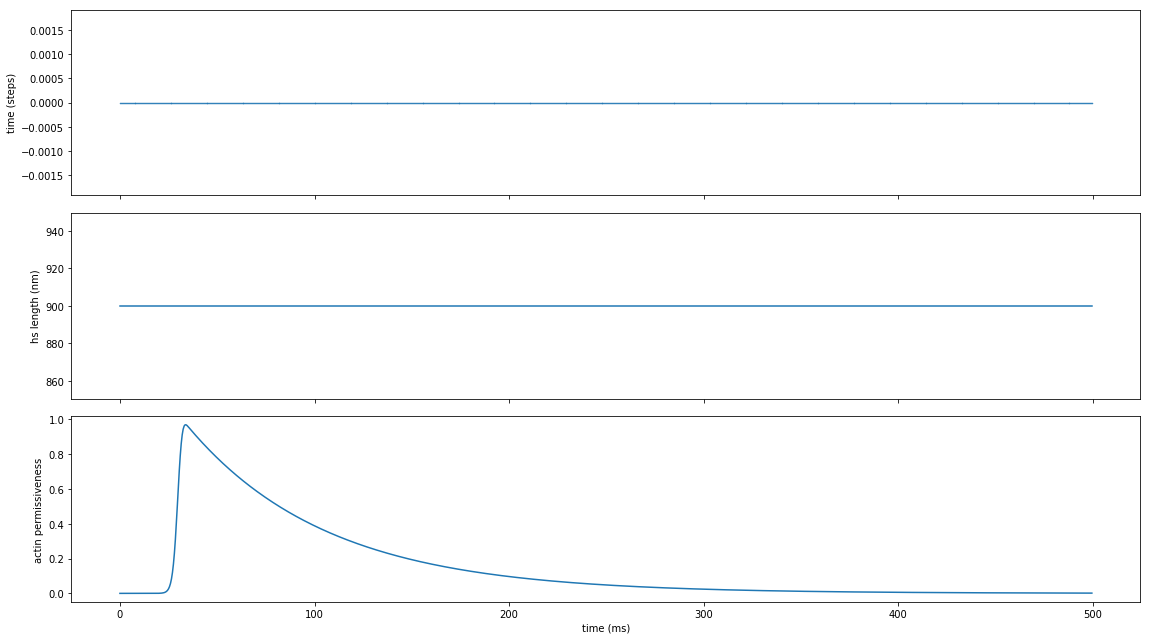

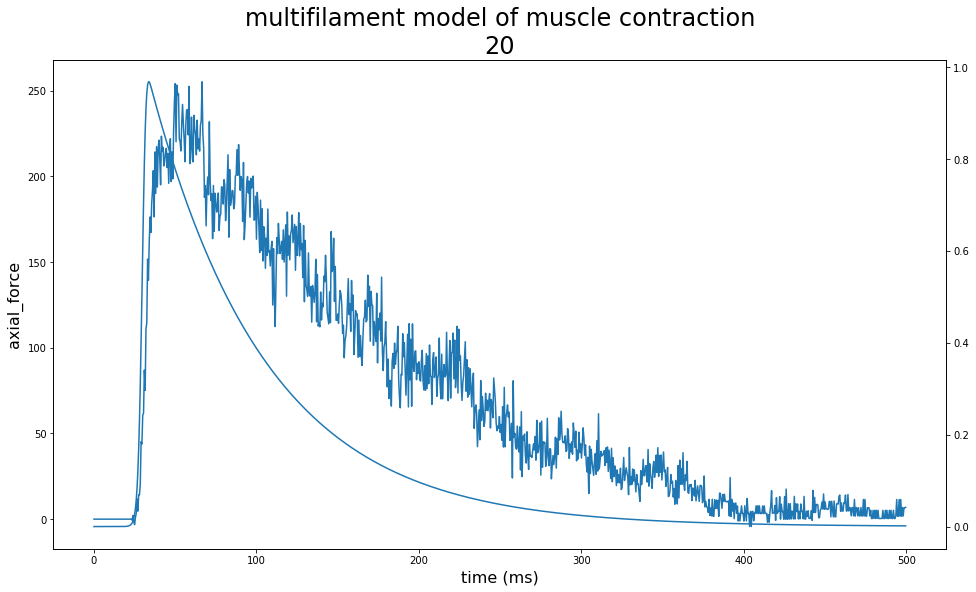

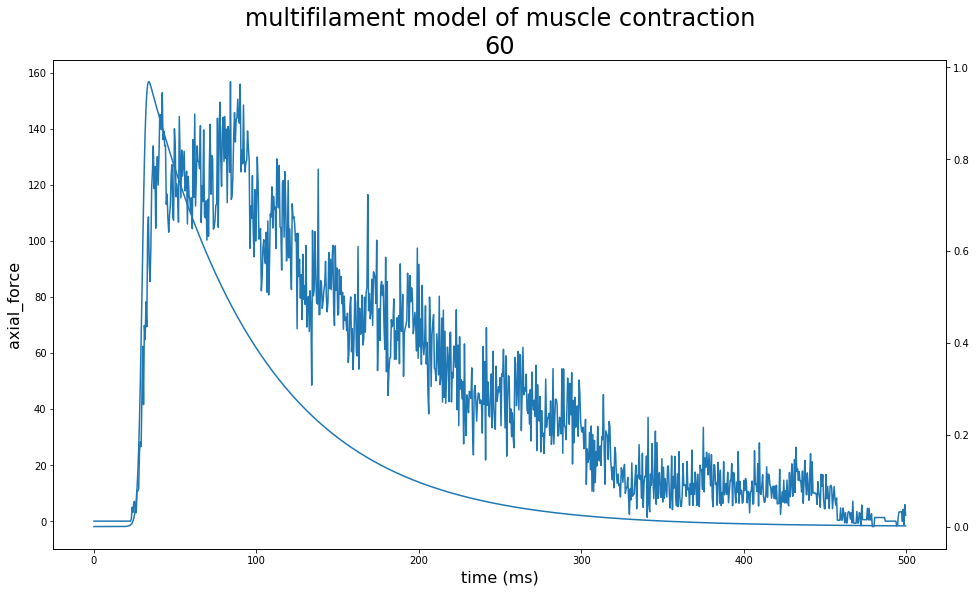

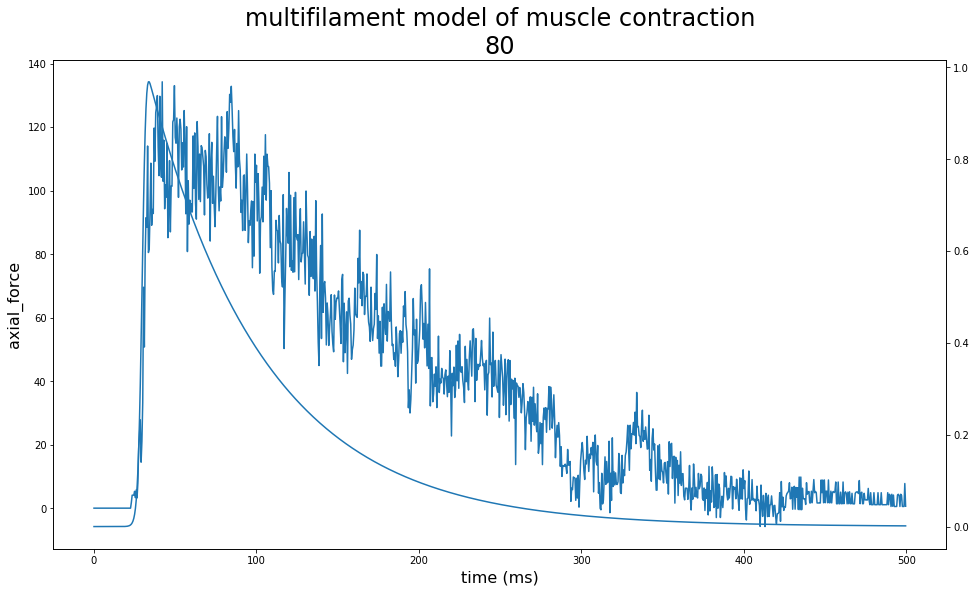

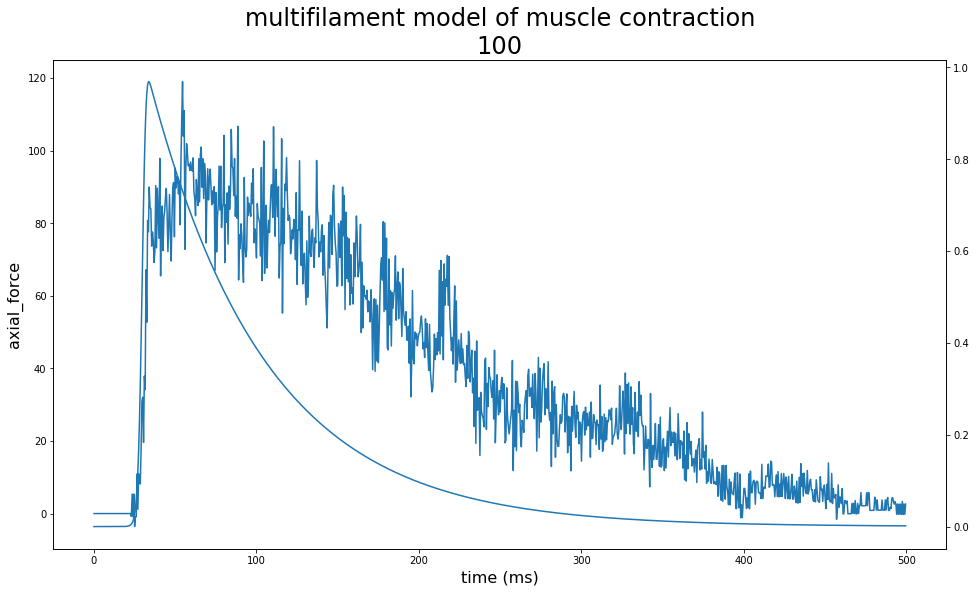

In [11]:
fig, axes = plt.subplots(3,1,sharex=True, figsize=(16,9))
axes[0].scatter(time_trace, np.full(len(time_trace), 0), s=0.25)
axes[0].set(ylabel='time (steps)')
axes[1].plot(time_trace, length_trace)
axes[1].set(ylabel='hs length (nm)')
axes[2].plot(time_trace, actin_permissiveness_trace)
axes[2].set(ylabel='actin permissiveness',
           xlabel='time (ms)')
plt.tight_layout()

output_dir = "../_originalTransitionRates/"

params = {"ti_a":0,
          "mh_c_ks":0.5, "mh_c_kw":0.5, "mh_c_rs":0.5, "mh_c_rw":0.5,
          "mh_g_ks":0.5, "mh_g_kw":0.5, "mh_g_rs":0.5, "mh_g_rw":0.5,}

for stiffness in [20, 60, 80, 100]:
    params = {"mh_c_ks":stiffness, "mh_c_kw":stiffness}

    wl_meta = multifil.aws.metas.emit(output_dir, # local dir to save run output to
                                      None, #s3 bucket to upload results to
                                      time_trace, 
                                      0.5, # poisson ratio, set to const vol here
                                     None, # intial ls, using default by passing none
                                     length_trace, 
                                     actin_permissiveness_trace, 
                                     str(stiffness), # comment describing run
                                     True, # whether to write out resulting file 
                                      #or just pass back to variable
                                     params)
    run_name = wl_meta['name']
    print(run_name)
    run_file = output_dir + run_name + ".meta.json"

    for key in wl_meta.keys():
        print(key)

    print(wl_meta['hs_params'])

    run_manager = multifil.aws.run.manage(run_file, False) # have run.py create the sarc from meta
    # Begin running
    run_manager.run_and_save()   # with our new sarc, run it

    print(run_name)
    data_name = run_file.split('.meta')[0] + '.data.json'

    with open(data_name, 'r') as file:
        data = json.load(file)

    for key in data.keys():
        print(key, end=", ")

    print()
    print()
    # print_constants(data['constants'])

    key = "axial_force"
    fs = 16

    # recreate time trace in milliseconds
    time_trace = data['timestep'].copy()
    for i in range(len(time_trace)):
        time_trace[i] *= data['timestep_length']

    # plot
    fig, axes = plt.subplots(figsize=(16, 9))
    axes.plot(time_trace, data[key])

    title = "multifilament model of muscle contraction\n" + wl_meta['comment']
    plt.title(title, fontsize=fs*1.5)
    plt.xlabel("time (ms)", fontsize=fs)
    plt.ylabel(key, fontsize=fs)

    ax2 = plt.twinx()
    ax2.plot(time_trace, data['actin_permissiveness'])

    save = True # OI! make sure you know whats going on here in this statement
    if save:
        plt.savefig(output_dir + str(run_name) + ".png")